# **NLP Standard Project**
## **Emotion Discovery and Reasoning its Flip in Conversation (EDiReF) - SemEval 2024 – Task 10 - Task C – EFR in English conversation:**
### Given a multiparty code-mixed conversation along with emotions for each utterance, the goal is to identify the trigger utterance for each emotionflip in the dialogue

In [2]:
# Some useful imports
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
import itertools
from collections import Counter
import random

# For BERT-baesd models
import torch
import transformers
from transformers import AutoTokenizer, BertTokenizer, BertModel, BertConfig
from torch.utils.data import DataLoader, Dataset
from torch import cuda
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
 
# For metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [3]:
# Set the device
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


# *DATA LOADING*

## Dataframe structure
Loading the JSON into a Pandas Dataframe and taking a first look to its structure:

In [4]:
# Load the JSON file and read it into a DataFrame
#file_path_train = '/kaggle/input/dataset/MELD_train_efr.json'
file_path_train = '/kaggle/input/dataset/MELD_train_efr (1).json'
#file_path_train = './Data/Task C/MELD_train_efr.json'
df = pd.read_json(file_path_train)

# Store a copy of the original DataFrame
original_df = df.copy()

df.shape

(4000, 5)

Each row represents an utterance in a conversation, with the corresponding speakers involved, the associated emotions, the text of the utterances, and numerical values indicating the presence of triggers for specific emotions.

In [4]:
# Take a look to data structure
df.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


# *PRE-PROCESSING*

## NaN values:
 Some trigger labels are not correctly formatted and appear as NaN values, so we convert them to 0 values to avoid errors.

In [38]:
# Count the number of NaN values
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 9


In [5]:
# Convert NaN values to 0
df["triggers"] = df["triggers"].apply(lambda x: [0 if elem != 1 and elem != 0 else elem for elem in x])

In [6]:
# Verify that all NaN values have been converted
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 0


## *DATA EXPLORATION*

We want to deal with imbalancing between the different values that 'emotions' and 'triggers' target labels can take.

In [7]:
# Flatten the lists to count occurrences of each value in the target labels
emotions_flat = [emotion for sublist in df['emotions'] for emotion in sublist]
triggers_flat = [trigger for sublist in df['triggers'] for trigger in sublist]

# Count occurrences
emotion_counts = Counter(emotions_flat)
trigger_counts = Counter(triggers_flat)

print("Emotion Counts:", emotion_counts)
print("Trigger Counts:", trigger_counts)

Emotion Counts: Counter({'neutral': 15263, 'joy': 6317, 'surprise': 4645, 'anger': 3964, 'sadness': 2648, 'fear': 1114, 'disgust': 1049})
Trigger Counts: Counter({0.0: 29425, 1.0: 5575})


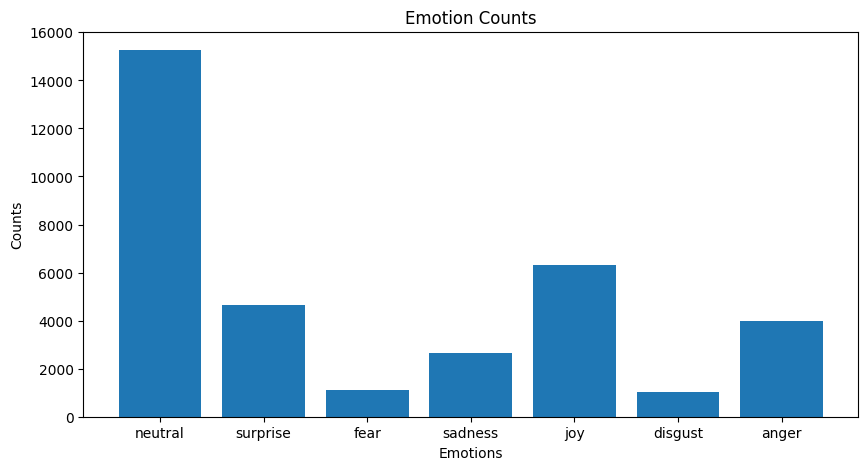

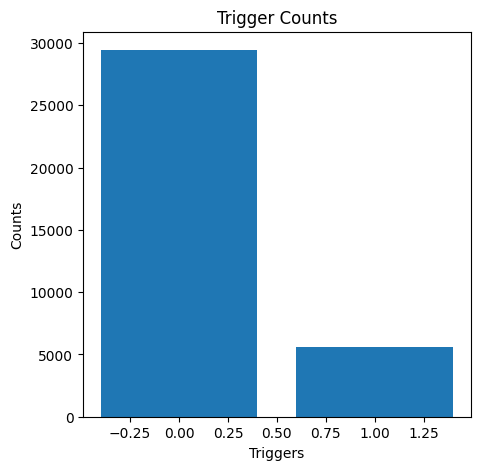

In [8]:
# Plot emotion counts
plt.figure(figsize=(10, 5))
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title('Emotion Counts')
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.show()

# Plot trigger counts
plt.figure(figsize=(5, 5))
plt.bar(trigger_counts.keys(), trigger_counts.values())
plt.title('Trigger Counts')
plt.xlabel('Triggers')
plt.ylabel('Counts')
plt.show()

### HANDLING IMBALANCING 

As we saw, data are indeed imbalanced. We will deal with this issue throug a combination of two methods: Data Augmentation through random word swapping and Class Weighting. Note that the second method is used later in the notebook. 

#### **Data Augmentation**

New Emotion Counts: Counter({'neutral': 32459, 'joy': 13489, 'surprise': 9922, 'anger': 8779, 'sadness': 5575, 'disgust': 3077, 'fear': 2469})
New Trigger Counts: Counter({0.0: 63476, 1.0: 12294})


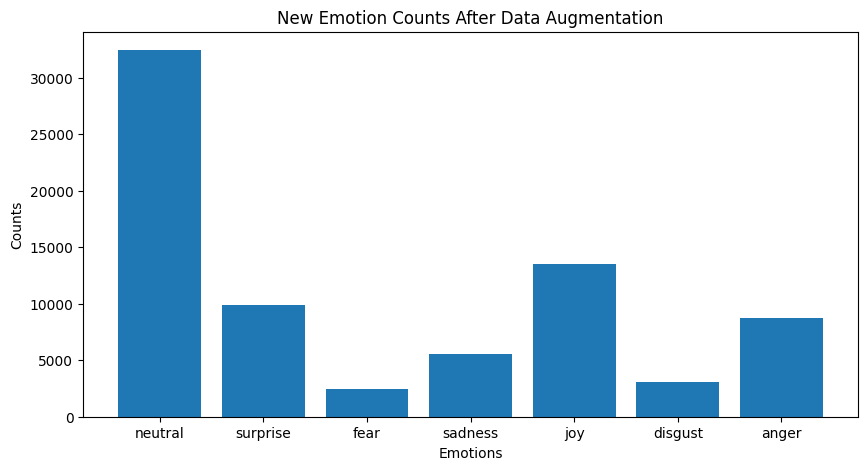

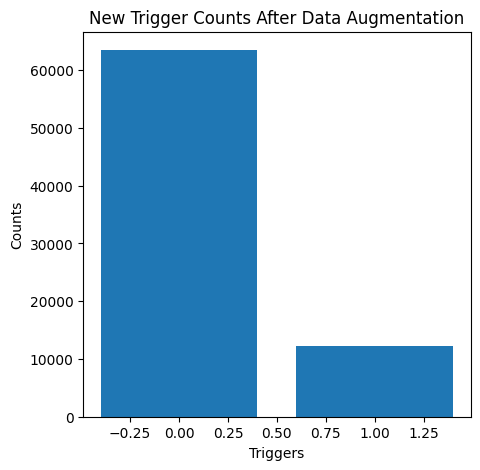

In [9]:
# Function for random word swapping
def random_swap(sentence, n=1):
    words = sentence.split()
    if len(words) < 2:
        return sentence
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Apply data augmentation to the imbalanced classes
def augment_data(df, target_column, n_swaps=1):
    augmented_data = []
    for index, row in df.iterrows():
        augmented_row = row.copy()
        augmented_row['utterances'] = [random_swap(utterance, n_swaps) for utterance in row['utterances']]
        augmented_data.append(augmented_row)
    return pd.DataFrame(augmented_data)

# Identify minority classes in 'emotions' and 'triggers'
emotion_counts = Counter([emotion for sublist in df['emotions'] for emotion in sublist])
trigger_counts = Counter([trigger for sublist in df['triggers'] for trigger in sublist])

# Define thresholds for minority classes (you can adjust these thresholds)
emotion_threshold = min(emotion_counts.values())
trigger_threshold = min(trigger_counts.values())

# Filter minority classes
minority_emotions = [emotion for emotion, count in emotion_counts.items() if count == emotion_threshold]
minority_triggers = [trigger for trigger, count in trigger_counts.items() if count == trigger_threshold]

# Augment data for minority classes
df_minority_emotions = df[df['emotions'].apply(lambda x: any(emotion in minority_emotions for emotion in x))]
df_minority_triggers = df[df['triggers'].apply(lambda x: any(trigger in minority_triggers for trigger in x))]

augmented_df_emotions = augment_data(df_minority_emotions, 'emotions')
augmented_df_triggers = augment_data(df_minority_triggers, 'triggers')

# Combine original and augmented data
combined_df = pd.concat([df, augmented_df_emotions, augmented_df_triggers])

# Flatten the lists to prepare for further processing
X_flat = [utterance for sublist in combined_df['utterances'] for utterance in sublist]
y_emotions_flat = [emotion for sublist in combined_df['emotions'] for emotion in sublist]
y_triggers_flat = [trigger for sublist in combined_df['triggers'] for trigger in sublist]

# Reshape back to original structure
dialogue_lengths = [len(utterances) for utterances in combined_df['utterances']]

def split_into_dialogues(data, lengths):
    split_data = []
    idx = 0
    for length in lengths:
        split_data.append(data[idx:idx + length])
        idx += length
    return split_data

# Split the data back into dialogues
X_resampled_dialogues = split_into_dialogues(X_flat, dialogue_lengths)
y_emotions_resampled_dialogues = split_into_dialogues(y_emotions_flat, dialogue_lengths)
y_triggers_resampled_dialogues = split_into_dialogues(y_triggers_flat, dialogue_lengths)

# Define a new DataFrame
new_df = pd.DataFrame({
    'utterances': X_resampled_dialogues,
    'emotions': y_emotions_resampled_dialogues,
    'triggers': y_triggers_resampled_dialogues
})

# Flatten the lists to count occurrences
emotions_flat = [emotion for sublist in new_df['emotions'] for emotion in sublist]
triggers_flat = [trigger for sublist in new_df['triggers'] for trigger in sublist]

# Count occurrences
emotion_counts = Counter(emotions_flat)
trigger_counts = Counter(triggers_flat)

print("New Emotion Counts:", emotion_counts)
print("New Trigger Counts:", trigger_counts)

# Plot emotion counts
plt.figure(figsize=(10, 5))
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title('New Emotion Counts After Data Augmentation')
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.show()

# Plot trigger counts
plt.figure(figsize=(5, 5))
plt.bar(trigger_counts.keys(), trigger_counts.values())
plt.title('New Trigger Counts After Data Augmentation')
plt.xlabel('Triggers')
plt.ylabel('Counts')
plt.show()

## Data Splitting
Here we split the DataFrame into training, test and validation sets using an 80/10/10 split as said in the project description. We then print the shape of each set.

In [10]:
# Split the DataFrame into training, validtion and test set
df_train, temp = train_test_split(new_df, test_size=0.2, shuffle=False)
df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

# Print the shape of each set
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (6736, 3)
Test shape: (842, 3)
Val shape: (842, 3)


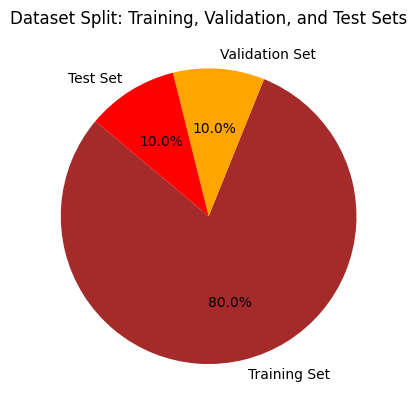

In [11]:
sizes = [len(df_train), len(df_val), len(df_test)]
labels = ['Training Set', 'Validation Set', 'Test Set']
colors = ['brown', 'orange', 'red']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split: Training, Validation, and Test Sets')
plt.show()

We noticed that a single dialogue appears at the end of the training set and the beginning of the test set. To avoid this overlap and ensure the dialogue is contained within only one set, we decided to adjust the data split slightly.

In [13]:
print(f"Dialogue in the last row of df_train: {df_train['utterances'][6735]}")

Dialogue in the last row of df_train: ['body? you have any respect for your Do', "to you realise what you're-you're doing Don't yourself?", "Hey, y'know, I have cancer it with you guys and your had and your emphysema and your heart disease.", 'The bottom line is, smoking is cool, you and know it.']


In [14]:
print(f"Dialogue in the first row of df_test: {df_test['utterances'][6736]}")

Dialogue in the first row of df_test: ['body? you have any respect for your Do', "Don't you yourself? what you're-you're doing to realise", "Hey, y'know, I have had it heart you guys and your cancer and your emphysema and your with disease.", 'The bottom it. is, smoking is cool, and you know line', "Chandler? It's you. he wants to speak to Alan,", 'Really?']


In [15]:
print(f"The dialogue continues until utterance 6744:")
print(f"Dialogue: {df_test['utterances'][6744]}")

The dialogue continues until utterance 6744:
Dialogue: ['Oh, look look look.', "The last candle's about burn to out."]


In [16]:
print(f"Dialogue in the last row of df_test: {df_test['utterances'][7577]}")

Dialogue in the last row of df_test: ['Hey!', "anything? sorry I'm late, did I miss I'm", 'Joey 15 stuffing', 'an Your personal best! (Ross takes 15?', 'you? were Where', 'Oh, on a date. this I met Yeah, girl on the train going to a museum upstate.', 'her? yeah! How did you meet Oh,', 'Oh, museum? which', 'No, his. answer', "Okay, it was just me and her at the back of the train, and I sat near the door, so she'd have to pass by me if she wanted switch to cars.", 'She mercy. totally at my was', 'Were you so were because you late burring this woman?', "she I'm getting back down \x91cause No, lives in Poughkeepsie.", "She seems really great, but she's like totally great, hours she lives two and a half but away.", "she can How be great if she's from Poughkeepsie? That joke would've killed in Albany."]


In [17]:
print(f"Dialogue in the first row of df_val: {df_val['utterances'][7578]}")

Dialogue in the first row of df_val: ['way! there is no No, It can', 'Why is family your', 'He cannot our at play wedding!']


In [12]:
# Reshape the sets to take into account this observation
df_train = new_df.iloc[:6744,:]
temp = new_df.iloc[6744:,:]

df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

# Print the new shape of the three sets
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (6744, 3)
Test shape: (838, 3)
Val shape: (838, 3)


We make a similar observation printing the last utterance of validation set and the first one of test set:

In [19]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][7581]}")

Dialouge in the last row of df_test: ['Oh, Yikes! want to look too! . I', 'So trying you think that these pictures\x97Are, are they do to tell a story?', 'sure. yeah, Oh,', "I mean, her in the case of this young woman, she has lost like clothes, so she rides naked on the horse, she's crying out, \x91Where are they, where are they?'", "Well, she's not going to find in lying them the grass like that.", 'Oh, yeah. Aw, remember the days when you your to go out to the barn, lift up used shirt, and bend over?', 'Yeah.', 'You see, would I now, date this girl.', "She's know, she's outdoorsy, you cute, and she knows how to build a fire.", "I got that's mean, to come in handy", "Okay, I've got a If question. you had to pick one of us to date, who would it be?", "don't I know.", 'neither. Me', 'Rachel.', 'What?!']


In [20]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][7582]}")

Dialouge in the first row of df_val: ["Look, I wanted to tell you sorry I'm-I'm lost.", "Listen, I've got a secret for let I ya. him win.", 'a that Is secret or a lie.']


**The final shape of data is the following:**

In [13]:
# Print the final shape of the sets
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (6744, 3)
Test shape: (838, 3)
Val shape: (838, 3)


Here we can see the real dimensions of the sets. We have opted to maintain this division because the dimensions of the sets are quite similar. Additionally, keeping the same dialogues together in the same sets ensures consistency and coherence.

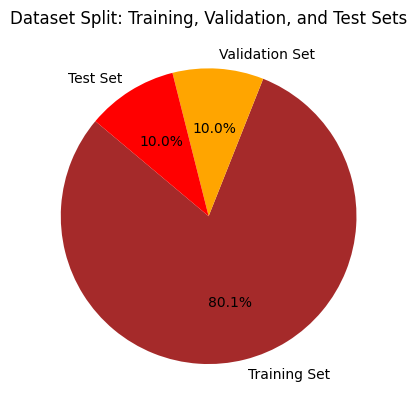

In [14]:
sizes = [len(df_train), len(df_val), len(df_test)]
labels = ['Training Set', 'Validation Set', 'Test Set']
colors = ['brown', 'orange', 'red']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split: Training, Validation, and Test Sets')
plt.show()

#### **Class Weighting**

We perform this pre-procesing method for dealing with imbalanced data without losing track of each dialogue's context.

In [15]:
# Assuming df_train, df_val, and df_test are already defined
# Extract the labels from the training set
y_train_emotions = [emotion for sublist in df_train['emotions'] for emotion in sublist]
y_train_triggers = [trigger for sublist in df_train['triggers'] for trigger in sublist]

# Calculate class weights for emotions
emotion_classes = np.unique(y_train_emotions)
emotion_class_weights = compute_class_weight(class_weight='balanced', classes=emotion_classes, y=y_train_emotions)
emotion_class_weights_dict = {emotion: weight for emotion, weight in zip(emotion_classes, emotion_class_weights)}

# Calculate class weights for triggers
trigger_classes = np.unique(y_train_triggers)
trigger_class_weights = compute_class_weight(class_weight='balanced', classes=trigger_classes, y=y_train_triggers)
trigger_class_weights_dict = {trigger: weight for trigger, weight in zip(trigger_classes, trigger_class_weights)}

print("Emotion Class Weights:", emotion_class_weights_dict)
print("Trigger Class Weights:", trigger_class_weights_dict)

Emotion Class Weights: {'anger': 1.2353383458646616, 'disgust': 3.312139043260325, 'fear': 4.2801520805463635, 'joy': 0.8101146055437101, 'neutral': 0.33537086585937714, 'sadness': 1.9831990343522656, 'surprise': 1.0700380201365909}
Trigger Class Weights: {0.0: 0.5904102404723981, 1.0: 3.2651734880223438}


## *MODEL DEFINITION*

### **BERT-based models**

### Tokenization

In [31]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize dialogues
def tokenize_dialogues(df, tokenizer):
    tokenized_data = []
    for index, row in df.iterrows():
        dialogue = row['utterances']
        # Tokenize the entire dialogue (list of sentences)
        tokenized_dialogue = tokenizer(dialogue, padding=True, truncation=True, return_tensors='pt')
        tokenized_data.append({
            'input_ids': tokenized_dialogue['input_ids'],
            'attention_mask': tokenized_dialogue['attention_mask'],
            'emotions': row['emotions'],
            'triggers': row['triggers']
        })
    return tokenized_data

In [17]:
# Tokenize the training, validation, and test sets
tokenized_train = tokenize_dialogues(df_train, tokenizer)
tokenized_val = tokenize_dialogues(df_val, tokenizer)
tokenized_test = tokenize_dialogues(df_test, tokenizer)

### Batches definition

In [18]:
# Custom Dataset class to handle the tokenized data
class DialogueDataset(Dataset):
    def __init__(self, tokenized_data):
        self.tokenized_data = tokenized_data

    def __len__(self):
        return len(self.tokenized_data)

    def __getitem__(self, idx):
        item = self.tokenized_data[idx]
        return {
            'input_ids': item['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': item['attention_mask'].squeeze(0),  # Remove batch dimension
            'emotions': item['emotions'],
            'triggers': item['triggers']
        }

# Create DataLoader for each set with batch_size = 1
def create_dataloader(tokenized_data, batch_size=1):
    dataset = DialogueDataset(tokenized_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

In [19]:
# Create DataLoaders for train, validation, and test sets
train_dataloader = create_dataloader(tokenized_train, batch_size=1)
val_dataloader = create_dataloader(tokenized_val, batch_size=1)
test_dataloader = create_dataloader(tokenized_test, batch_size=1)

In [20]:
print(train_dataloader.dataset[0])

{'input_ids': tensor([[  101,  2036,  1045,  2001,  1996,  2391,  2711,  2006,  2026,  2194,
          1005,  1055,  6653,  2013,  1996,  1047,  2140,  1011,  1019,  2000,
         24665,  1011,  1020,  2291,  1012,   102],
        [  101,  2017,  2442,  1005,  2310,  2018,  2115,  2398,  2440,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  2008,  1045,  2106,  1012,  2008,  1045,  2106,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  2061,  2292,  1005,  1055,  2831,  1037,  2210,  2978,  2055,
          2115,  5704,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  2026,  5704,  1029,  2035,  2157,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,   

### BERT-based models definition

The following definition is slightly different from the original one: all the modifications are made in order to feed entire dialogues as inputs to the models.

In [36]:
# Define the custom model class
class BertForEmotionAndTriggerClassification(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertForEmotionAndTriggerClassification, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.config = BertConfig.from_pretrained('bert-base-uncased')
        
        # Freeze BERT layers if specified
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        # Define the classifier layers
        self.emotion_classifier = nn.Linear(self.config.hidden_size, len(emotion_classes))
        self.trigger_classifier = nn.Linear(self.config.hidden_size, 1)  # Assuming triggers are numeric

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        
        emotion_logits = self.emotion_classifier(pooled_output)
        trigger_logits = self.trigger_classifier(pooled_output)
        
        return emotion_logits, trigger_logits

In [74]:
# Initialize the models
freezed_model = BertForEmotionAndTriggerClassification(freeze_bert=True)
full_model = BertForEmotionAndTriggerClassification(freeze_bert=False)

freezed_model.to(device)
full_model.to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BertForEmotionAndTriggerClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

In [75]:
# Convert class weights to tensors
emotion_class_weights_tensor = torch.tensor(list(emotion_class_weights_dict.values()), dtype=torch.float).to(device)
trigger_class_weights_tensor = torch.tensor(list(trigger_class_weights_dict.values()), dtype=torch.float).to(device)

# Label encoding for emotions
emotion_label_encoder = LabelEncoder()
emotion_label_encoder.fit(y_train_emotions)

# Example of training loop
def train_model(model, train_dataloader, val_dataloader, epochs=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss(weight=emotion_class_weights_tensor)  # For emotions
    mse_loss_fn = nn.MSELoss()  # For triggers

    for epoch in range(epochs):
        model.train()
        for batch in train_dataloader:
            input_ids = batch['input_ids'][0].to(device)  # Ensure correct shape
            attention_mask = batch['attention_mask'][0].to(device)  # Ensure correct shape
            emotions = batch['emotions']
            triggers = batch['triggers']

            # Convert emotions to integer class indices
            emotions = emotion_label_encoder.transform(np.array(emotions).ravel())  # Ensure 1D array

            optimizer.zero_grad()
            emotion_logits, trigger_logits = model(input_ids, attention_mask)
            
            # Calculate loss
            emotion_loss = loss_fn(emotion_logits, torch.tensor(emotions, dtype=torch.long).to(device))
            trigger_loss = mse_loss_fn(trigger_logits.squeeze(), torch.tensor(triggers).to(device).float())
            loss = emotion_loss + trigger_loss
            
            loss.backward()
            optimizer.step()

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'][0].to(device)  # Ensure correct shape
                attention_mask = batch['attention_mask'][0].to(device)  # Ensure correct shape
                emotions = batch['emotions']
                triggers = batch['triggers']

                # Convert emotions to integer class indices
                emotions = emotion_label_encoder.transform(np.array(emotions).ravel())  # Ensure 1D array

                emotion_logits, trigger_logits = model(input_ids, attention_mask)
                
                # Calculate loss
                emotion_loss = loss_fn(emotion_logits, torch.tensor(emotions, dtype=torch.long).to(device))
                trigger_loss = mse_loss_fn(trigger_logits.squeeze(), torch.tensor(triggers).to(device).float())
                val_loss += emotion_loss.item() + trigger_loss.item()

        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss / len(val_dataloader)}")

In [67]:
# Train the models
train_model(freezed_model, train_dataloader, val_dataloader, epochs=3)

Epoch 1, Validation Loss: 1.9067928098577802
Epoch 2, Validation Loss: 1.8885256600230576
Epoch 3, Validation Loss: 1.8757432398157359


In [76]:
train_model(full_model, train_dataloader, val_dataloader, epochs=3)

Epoch 1, Validation Loss: 1.4299307524722273
Epoch 2, Validation Loss: 1.0220145033150112
Epoch 3, Validation Loss: 0.8296036762477128


In [86]:
# Example of evaluation loop
def evaluate_model(model, test_dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'][0].to(device)  # Ensure correct shape
            attention_mask = batch['attention_mask'][0].to(device)  # Ensure correct shape
            emotions = batch['emotions']
            triggers = batch['triggers']

            # Convert emotions to integer class indices
            emotions = emotion_label_encoder.transform(np.array(emotions).ravel())

            emotion_logits, trigger_logits = model(input_ids, attention_mask)
            
             # Get predictions
            emotion_preds = torch.argmax(emotion_logits, dim=1).cpu().numpy()  # Move to CPU and convert to NumPy
            trigger_preds = (trigger_logits.squeeze() > 0.5).cpu().numpy()  # Move to CPU and convert to NumPy
            
            predictions.append((emotion_preds, trigger_preds))

    return predictions

In [87]:
# Evaluate the models
freezed_model_predictions = evaluate_model(freezed_model, test_dataloader)
full_model_predictions = evaluate_model(full_model, test_dataloader)

# Print example predictions
print("Freezed Model Predictions:", freezed_model_predictions[:1])
print("Full Model Predictions:", full_model_predictions[:1])

Freezed Model Predictions: [(array([2, 2]), array([False, False]))]
Full Model Predictions: [(array([6, 4]), array([False, False]))]


### Evaluation - F1 score definition for the two models



In [93]:
# Function to calculate Average F1 Score
def calculate_average_f1_score(predictions, df_test):
    f1_scores = []
    for i, (emotion_preds, trigger_preds) in enumerate(predictions):
        true_emotions = df_test.iloc[i]['emotions']
        true_triggers = df_test.iloc[i]['triggers']
        
        # Convert true emotions to integer class indices
        true_emotions = emotion_label_encoder.transform(np.array(true_emotions).ravel())  # Ensure 1D array
        
        # Calculate F1 score for emotions and triggers
        f1_emotions = f1_score(true_emotions, emotion_preds, average='weighted')
        f1_triggers = f1_score(true_triggers, trigger_preds, average='weighted')
        
        f1_scores.append((f1_emotions + f1_triggers) / 2)
    
    return np.mean(f1_scores)

# Function to calculate Unrolled F1 Score and Per-Category Unrolled F1 Score
def calculate_unrolled_f1_score(predictions, df_test):
    all_true_emotions = []
    all_pred_emotions = []
    all_true_triggers = []
    all_pred_triggers = []
    
    for i, (emotion_preds, trigger_preds) in enumerate(predictions):
        true_emotions = df_test.iloc[i]['emotions']
        true_triggers = df_test.iloc[i]['triggers']
        
        # Convert true emotions to integer class indices
        true_emotions = emotion_label_encoder.transform(np.array(true_emotions).ravel())  # Ensure 1D array
        
        # Unroll the predictions and true values
        all_true_emotions.extend(true_emotions)
        all_pred_emotions.extend(emotion_preds)
        all_true_triggers.extend(true_triggers)
        all_pred_triggers.extend(trigger_preds)
    
    # Calculate F1 score for unrolled emotions and triggers
    f1_emotions = f1_score(all_true_emotions, all_pred_emotions, average='weighted')
    f1_triggers = f1_score(all_true_triggers, all_pred_triggers, average='weighted')
    
    # Calculate per-category F1 scores for emotions
    emotion_f1_scores = {}
    for emotion in emotion_classes:
        emotion_idx = emotion_label_encoder.transform([emotion])[0]
        emotion_f1_scores[emotion] = f1_score(
            [1 if e == emotion_idx else 0 for e in all_true_emotions],
            [1 if e == emotion_idx else 0 for e in all_pred_emotions],
            average='weighted'
        )
    
    # Calculate per-category F1 scores for triggers
    trigger_f1_scores = {}
    for trigger in trigger_classes:
        trigger_f1_scores[trigger] = f1_score(
            [1 if t == trigger else 0 for t in all_true_triggers],
            [1 if t == trigger else 0 for t in all_pred_triggers],
            average='weighted'
        )
    
    return (f1_emotions + f1_triggers) / 2, emotion_f1_scores, trigger_f1_scores, all_true_emotions, all_pred_emotions, all_true_triggers, all_pred_triggers


In [94]:
# Calculate the metrics
average_f1_score_freezed = calculate_average_f1_score(freezed_model_predictions, df_test)
unrolled_f1_score_freezed, emotion_f1_scores_freezed, trigger_f1_scores_freezed, true_emotions_freezed, pred_emotions_freezed, true_triggers_freezed, pred_triggers_freezed = calculate_unrolled_f1_score(freezed_model_predictions, df_test)

average_f1_score_full = calculate_average_f1_score(full_model_predictions, df_test)
unrolled_f1_score_full, emotion_f1_scores_full, trigger_f1_scores_full, true_emotions_full, pred_emotions_full, true_triggers_full, pred_triggers_full = calculate_unrolled_f1_score(full_model_predictions, df_test)

# Print the results
print("Freezed Model - Average F1 Score:", average_f1_score_freezed)
print("Freezed Model - Unrolled F1 Score:", unrolled_f1_score_freezed)
print("Freezed Model - Per-Category Unrolled F1 Scores for Emotions:", emotion_f1_scores_freezed)
print("Freezed Model - Per-Category Unrolled F1 Scores for Triggers:", trigger_f1_scores_freezed)

print("Full Model - Average F1 Score:", average_f1_score_full)
print("Full Model - Unrolled F1 Score:", unrolled_f1_score_full)
print("Full Model - Per-Category Unrolled F1 Scores for Emotions:", emotion_f1_scores_full)
print("Full Model - Per-Category Unrolled F1 Scores for Triggers:", trigger_f1_scores_full)

Freezed Model - Average F1 Score: 0.32500912921060615
Freezed Model - Unrolled F1 Score: 0.34805803773316696
Freezed Model - Per-Category Unrolled F1 Scores for Emotions: {'anger': 0.8522423717120805, 'disgust': 0.9566074034152131, 'fear': 0.09414686113604938, 'joy': 0.7012242361703552, 'neutral': 0.38791199071016574, 'sadness': 0.8899130134639974, 'surprise': 0.8227876422874568}
Freezed Model - Per-Category Unrolled F1 Scores for Triggers: {0.0: 0.6909527930162822, 1.0: 0.6909527930162822}
Full Model - Average F1 Score: 0.7438950472880944
Full Model - Unrolled F1 Score: 0.7698320628496365
Full Model - Per-Category Unrolled F1 Scores for Emotions: {'anger': 0.9529824402644564, 'disgust': 0.9920994190407861, 'fear': 0.9870739167131867, 'joy': 0.9322773242179985, 'neutral': 0.8929384140765848, 'sadness': 0.9593554528269637, 'surprise': 0.9565739009257826}
Full Model - Per-Category Unrolled F1 Scores for Triggers: {0.0: 0.7021935080623436, 1.0: 0.7021935080623436}


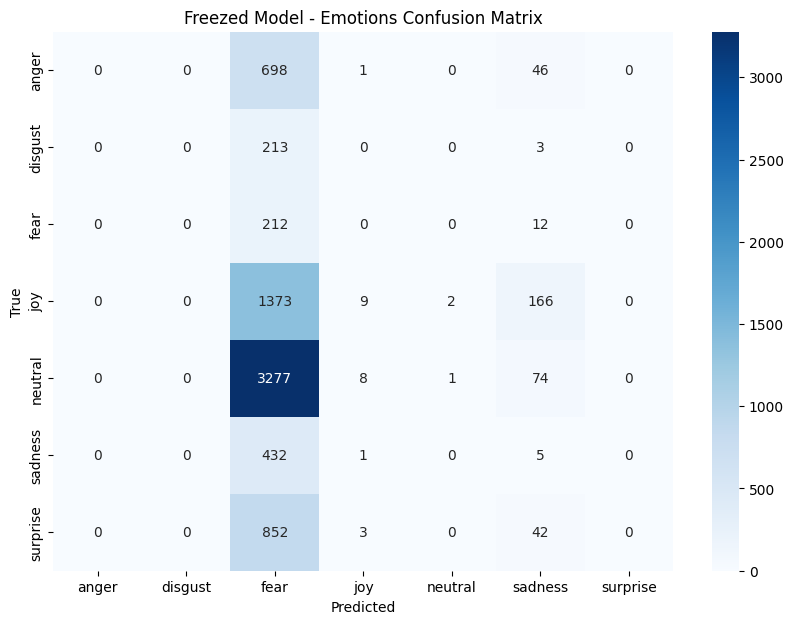

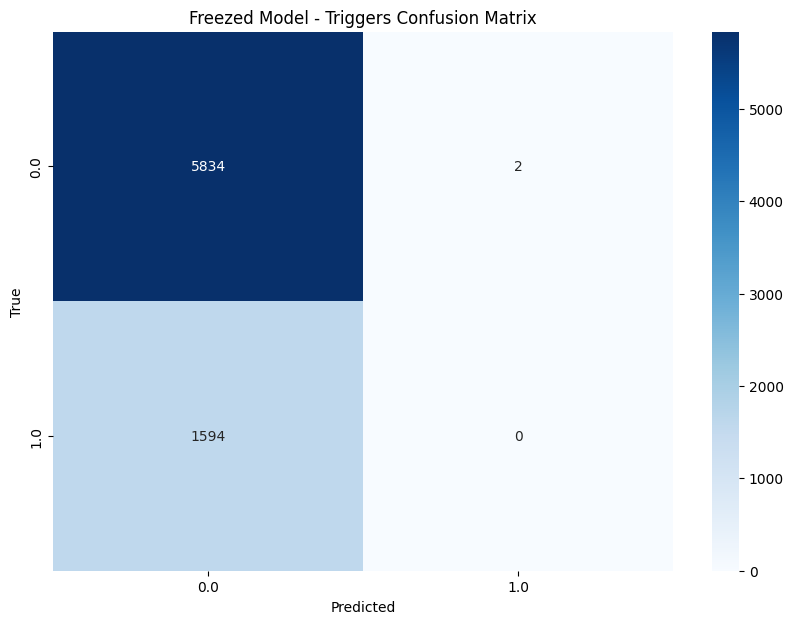

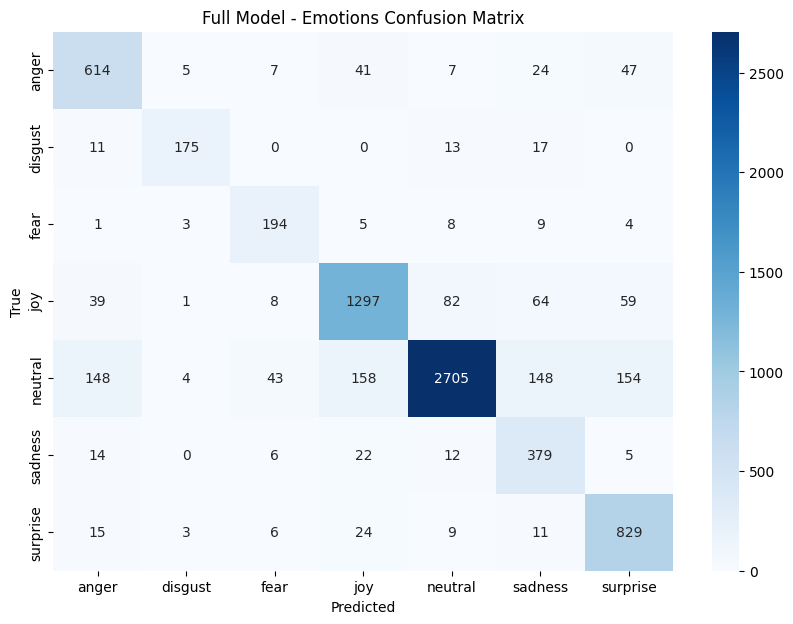

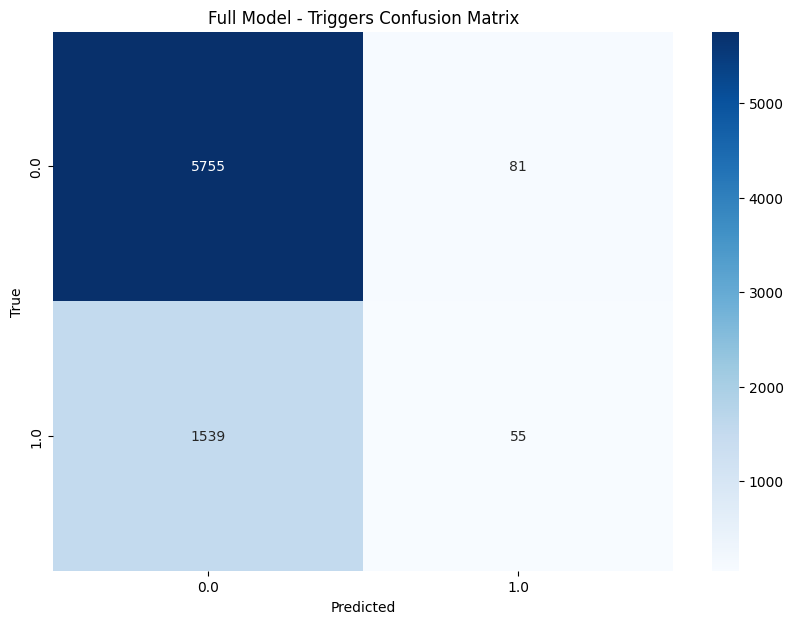

In [98]:
# Function to plot confusion matrix
def plot_confusion_matrix_triggers(true_labels, pred_labels, classes, title):
    unique_labels = np.unique(true_labels)
    cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def plot_confusion_matrix_emotions(true_labels, pred_labels, classes, title):
    unique_labels = np.unique(true_labels)
    cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_label_encoder.inverse_transform(unique_labels), yticklabels=emotion_label_encoder.inverse_transform(unique_labels))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plot confusion matrices for emotions and triggers for the freezed model
plot_confusion_matrix_emotions(true_emotions_freezed, pred_emotions_freezed, emotion_classes, 'Freezed Model - Emotions Confusion Matrix')
plot_confusion_matrix_triggers(true_triggers_freezed, pred_triggers_freezed, trigger_classes, 'Freezed Model - Triggers Confusion Matrix')

# Plot confusion matrices for emotions and triggers for the full model
plot_confusion_matrix_emotions(true_emotions_full, pred_emotions_full, emotion_classes, 'Full Model - Emotions Confusion Matrix')
plot_confusion_matrix_triggers(true_triggers_full, pred_triggers_full, trigger_classes, 'Full Model - Triggers Confusion Matrix')